In [67]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [75]:
import os
import sys
import SALib
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from pygam import LinearGAM, s, f
from SALib.sample import saltelli
from SALib.analyze import sobol, delta
from itertools import combinations, product
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Load data
name = 'global_sensitivity_full'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")
segregation_data = pd.read_pickle(f"{path_to_frame}data/frame.pkl")

# Format data
# Construct a dictionary of name (key) and title for plots (value)
names_bounds = {'torus': 'Torus - [True, False]', 
                'household_density': 'Density - [0.5, 0.9]',
                'n_schools': 'Schools/n-hoods - [4, 9, 16, 25, 36, 49]',
                'single_utility_at_max': 'Utility at max - [0, 1]',
                'single_optimal_fraction': 'Optimal fraction - [0.5, 0.8]', 
                'radius': 'Radius - [1-10]', 
                'neighbourhood_mixture': 'Neighbourhood mix (b) - [0, 1]',
                'alpha': 'Alpha - [0, 1]', 
                'homophily_std':'Optimal fraction std. - [0.01, 0.3]',
                'max_move_fraction': '% agents moving - [0.2, 0.5]',
                'temperature':'Temperature - [10, 100]',
                'num_considered':'# Considered empty spots - [1, 10]',
                'school_capacity': 'School capacity - [2, 5]',
                'window_size':'Window size - [10,30]',
                'conv_threshold':'Convergence threshold - [0.005,0.01]',
                'max_res_steps': 'Maximum steps - [200, 400]',
                'dummy':'Dummy - [0, 1]'}

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names_bounds.values())
outcomes = {'res_seg_new': 'Residential Segregation (Theil)',
            'school_seg_new': 'School Segregation (Theil)'}
outcomes_to_plot = list(outcomes.values())

# Rename the columns
segregation_data.rename(columns=names_bounds, inplace=True)
segregation_data.rename(columns=outcomes, inplace=True)
if 'res_seg' in segregation_data.columns:
    segregation_data.drop(['res_seg', 'school_seg'], axis=1, inplace=True)
segregation_data['Difference in Segregation'] = \
    segregation_data['School Segregation (Theil)'] - \
    segregation_data['Residential Segregation (Theil)']
outcomes_to_plot += ['Difference in Segregation']

# Descriptive Statistics

       res_converged school_converged
count          19000            19000
unique             2                2
top             True             True
freq           18830            18933


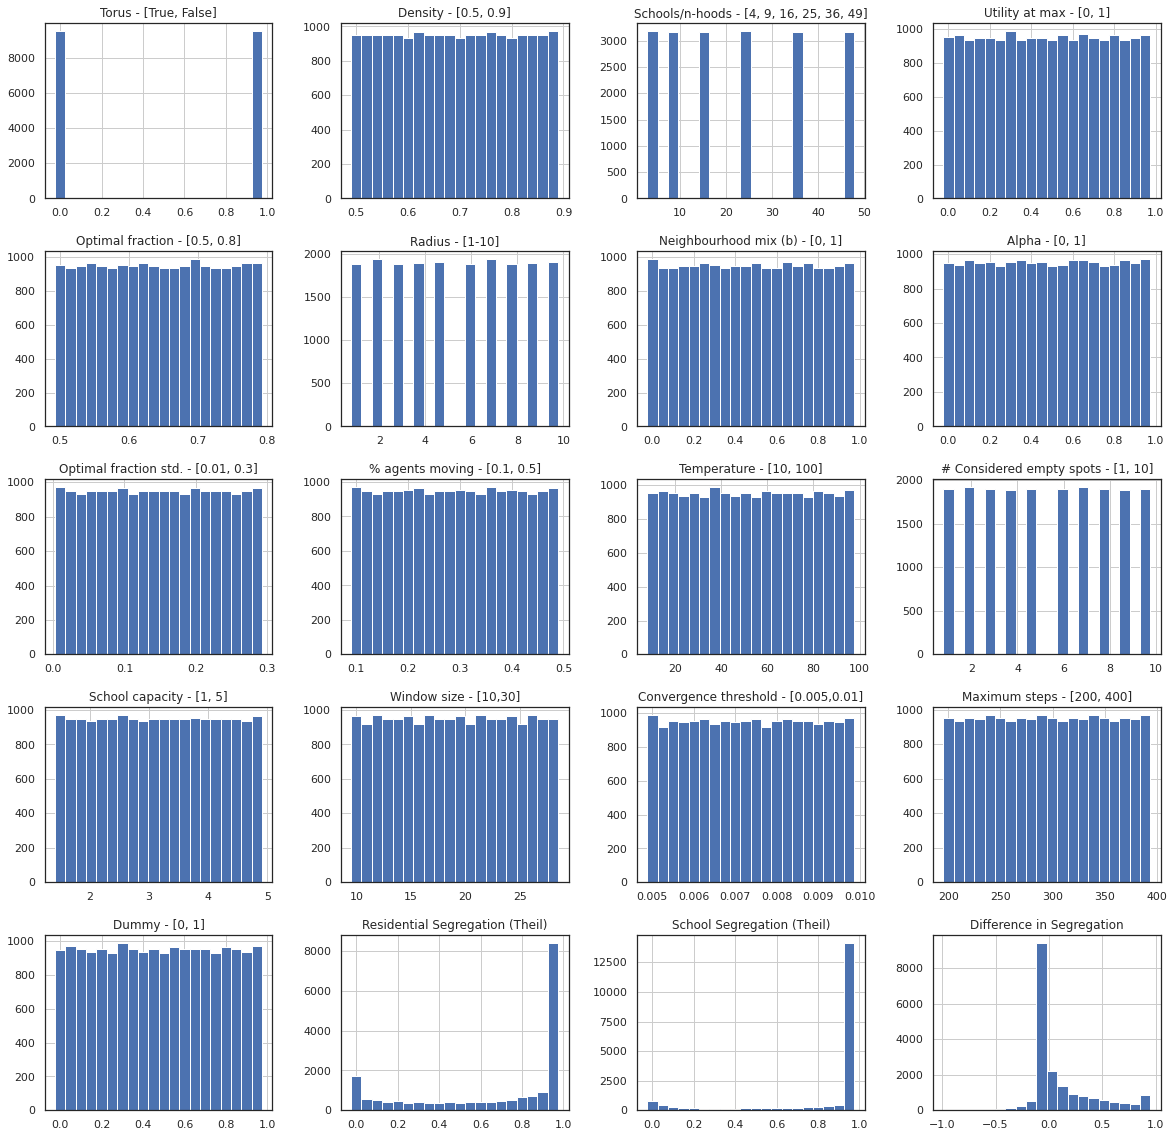

In [73]:
# Plot the distribution of the input parameters (i.e., Sobol sequence) as sanity check
sns.set_theme(style='white', font_scale=1)
hist_columns = columns_to_plot + outcomes_to_plot
_ = segregation_data.hist(column=hist_columns, figsize=(20,20), 
                          align='left', bins=20, backend='matplotlib')

# Check how many processes converged
print(segregation_data[['res_converged', 'school_converged']].describe())

# Artificial dataset #1

In [147]:
from sklearn.datasets import make_regression
from scipy.special import expit, logit

# Variance function to model overdispersion
class vf(sm.families.varfuncs.VarianceFunction):
    def __call__(self, mu):
        return mu**2 * (1 - mu)**2

    def deriv(self, mu):
        return 2*mu - 6*mu**2 + 4*mu**3

bin = sm.families.Binomial()
bin.variance = vf()

# Create datasets
rng = np.random.RandomState(3)  # fix random state
X1, y1, coef1 = make_regression(n_samples=1000,
                                 n_features=5,
                                 n_informative=3,
                                 noise=5.0,
                                 coef=True,
                                 random_state=0)

# mapping the data to the interval [0,1]
y1 = expit(y1 / 50)   # the factor 50 just scales the data appropriately
result = sm.GLM(y1, sm.add_constant(X1, prepend=False), family=bin).fit(cov_type='HC0', scale='X2')

print("The data was generated with the following coefficients: ", coef1)
print("These are the parameter estimates: ", result.params*50)
print()
print(result.summary())

The data was generated with the following coefficients:  [10.715  0.     0.    66.499 41.206]
These are the parameter estimates:  [10.941  0.102 -0.156 66.552 41.608  0.057]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                        0.010076
Method:                          IRLS   Log-Likelihood:                -355.48
Date:                Tue, 13 Apr 2021   Deviance:                       1.8085
Time:                        16:04:35   Pearson chi2:                     10.0
No. Iterations:                     9                                         
Covariance Type:                  HC0                                         
                 coef    std err   

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.0417
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                         1000 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.0243
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9946
Feature Function                  Lam

/home/eric/.local/share/virtualenvs/compassproject-VU2Xbkhf/lib/python3.8/site-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/home/eric/.local/share/virtualenvs/compassproject-VU2Xbkhf/lib/python3.8/site-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
<ipython-input-113-5924c04c58be>:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


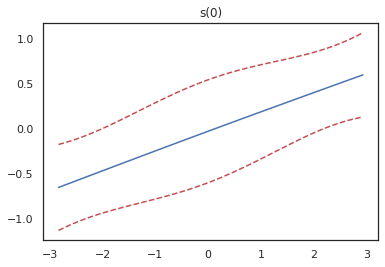

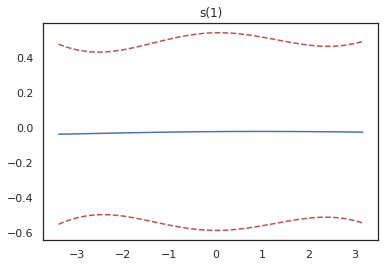

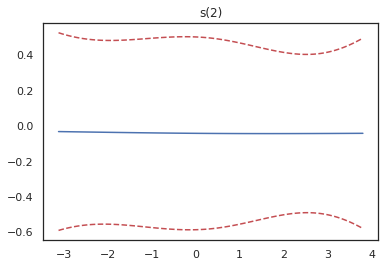

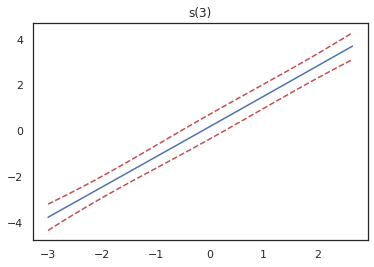

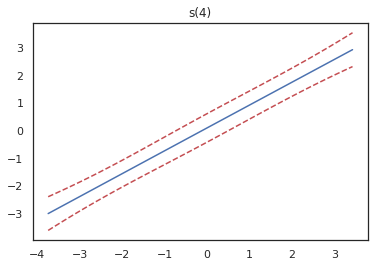

In [113]:
# Generalised Additive Models
from pygam import LinearGAM, LogisticGAM, s, f
gam = LogisticGAM(n_splines=5).fit(X1, y1)
gam.summary()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

# Artificial dataset #2

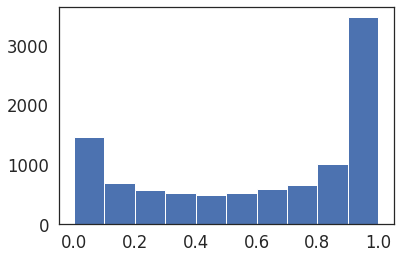

The data was generated with the following coefficients:  [-3.  -1.5  0.   1.5  3. ]
These are the parameter estimates:  [-2.696 -1.336  0.019  1.345  2.652  0.885]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9994
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0411
Method:                          IRLS   Log-Likelihood:                -2892.3
Date:                Tue, 13 Apr 2021   Deviance:                       1011.4
Time:                        16:07:53   Pearson chi2:                 1.04e+04
No. Iterations:                    14                                         
Covariance Type:                  HC0                                         
                 coef    std err          z  

In [148]:
rng = np.random.RandomState(3)  # fix random state

# Create the data
n_vars = 5
size = 10000
X2 = np.random.uniform(-1, 1, size=(size, n_vars))
coef2 = np.linspace(-3, 3, n_vars)
constant = 1
noise = np.random.normal(loc=0.0, scale=1, size=size)
multiplicated = constant + np.matmul(X2, coef2) + noise

# Transform and show distribution
y2 = np.exp(multiplicated) / (1 + np.exp(multiplicated))
plt.hist(y2)
plt.show()

# Fit the GLM
result = sm.GLM(y2, sm.add_constant(X2, prepend=False), family=bin).fit(cov_type='HC0', scale='X2')

print("The data was generated with the following coefficients: ", coef2)
print("These are the parameter estimates: ", result.params)
print()
print(result.summary())

/home/eric/.local/share/virtualenvs/compassproject-VU2Xbkhf/lib/python3.8/site-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/home/eric/.local/share/virtualenvs/compassproject-VU2Xbkhf/lib/python3.8/site-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
<ipython-input-115-d55046bf5a40>:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     13.0325
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                        10000 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.0048
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9982
Feature Function                  Lam

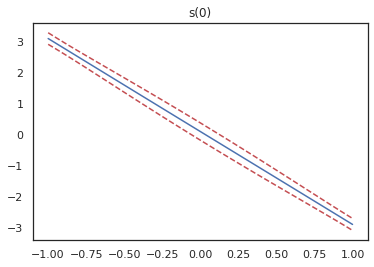

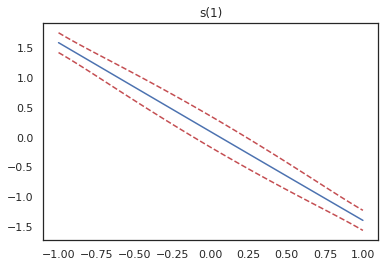

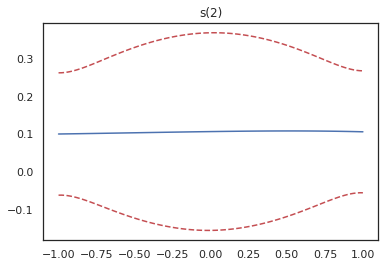

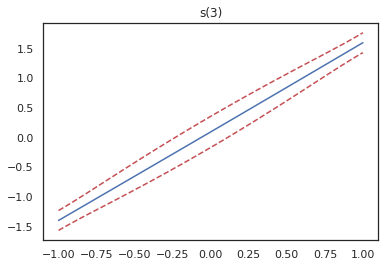

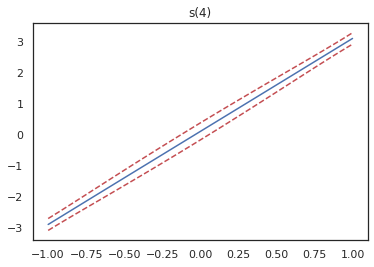

In [115]:
# Generalised Additive Models
gam = LogisticGAM(n_splines=5).fit(X2, y2)
gam.summary()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

# Mechanisms of segregation

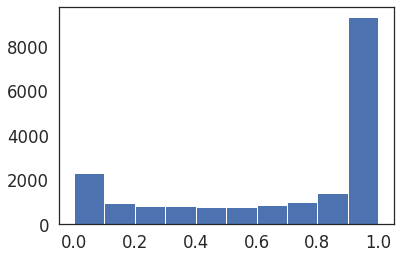

                        Generalized Linear Model Regression Results                        
Dep. Variable:     Residential Segregation (Theil)   No. Observations:                19000
Model:                                         GLM   Df Residuals:                    18972
Model Family:                             Binomial   Df Model:                           27
Link Function:                               logit   Scale:                         0.20950
Method:                                       IRLS   Log-Likelihood:                -4570.4
Date:                             Tue, 13 Apr 2021   Deviance:                       2485.1
Time:                                     16:12:19   Pearson chi2:                 3.97e+03
No. Iterations:                                 10                                         
Covariance Type:                               HC0                                         
                                               coef    std err          z      P

In [151]:
subset = [names_bounds[name] for name in ['single_optimal_fraction', #'alpha',
            'single_utility_at_max', 'radius', 'neighbourhood_mixture']]
X = segregation_data[columns_to_plot]
poly = PolynomialFeatures(2, include_bias=False)
X_interactions = poly.fit_transform(X[subset])
names = poly.get_feature_names([colname.split('-')[0][:16] for colname in subset])
X_interactions_named = pd.DataFrame(columns=names, data=X_interactions)

X_all = pd.concat([X_interactions_named, X.drop(subset, axis=1)], axis=1)
outcome = 'Residential Segregation (Theil)'
y = segregation_data[outcome]

plt.hist(y)
plt.show()

# Fit the GLM
result = sm.GLM(y, sm.add_constant(X_all, prepend=False), family=sm.families.Binomial()).fit(cov_type='HC0', scale='X2')
print(result.summary())

Text(0, 0.5, 'Residual')

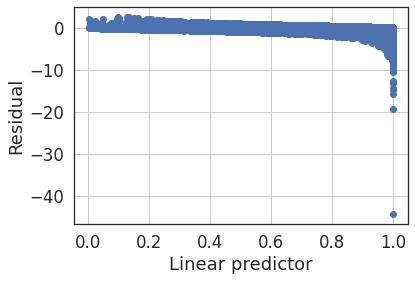

In [130]:
plt.clf()
plt.grid(True)
plt.plot(result.predict(), result.resid_pearson, 'o')
plt.xlabel("Linear predictor")
plt.ylabel("Residual")

# Feature importance, PDP and ICE plots

In [131]:
# First fit the tree-based models
np.random.seed(0)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = RandomForestRegressor(max_features='sqrt', max_depth=10, n_estimators=200, 
                              n_jobs=4, oob_score=True, random_state=0)
# model = GradientBoostingRegressor(n_estimators=500, max_depth=5, max_features='sqrt')

model.fit(X_train, Y_train)
print(model.oob_score_)
print(model.score(X_test, Y_test))

importances = model.feature_importances_
try:
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
except AttributeError:
    std = np.zeros(len(importances))
indices = np.argsort(importances)

0.8060428310448879
0.8181510246536434


Feature ranking:  School Segregation (Theil)
1. Torus - [True, False] (0.003999)
2. # Considered empty spots - [1, 10] (0.013355)
3. Window size - [10,30] (0.013716)
4. Optimal fraction std. - [0.01, 0.3] (0.017757)
5. Density - [0.5, 0.9] (0.018732)
6. Maximum steps - [200, 400] (0.019621)
7. Radius - [1-10] (0.020632)
8. Dummy - [0, 1] (0.022439)
9. % agents moving - [0.1, 0.5] (0.023256)
10. School capacity - [1, 5] (0.026273)
11. Schools/n-hoods - [4, 9, 16, 25, 36, 49] (0.026628)
12. Convergence threshold - [0.005,0.01] (0.029885)
13. Temperature - [10, 100] (0.032542)
14. Neighbourhood mix (b) - [0, 1] (0.063940)
15. Alpha - [0, 1] (0.149244)
16. Optimal fraction - [0.5, 0.8] (0.149566)
17. Utility at max - [0, 1] (0.368417)


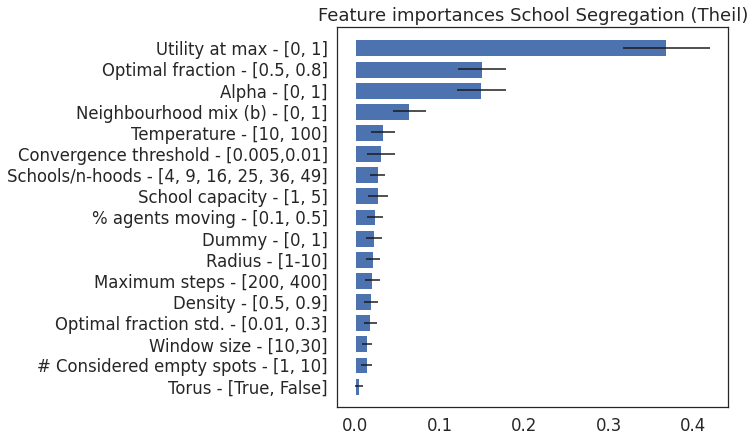

In [132]:
# Print the feature ranking

sns.set_theme(style='white', font_scale=1.5)
print("Feature ranking: ", outcome)

for f in range(X.shape[1]):
    index = indices[f]
    print("%d. %s (%f)" % (f + 1, X.columns[index], importances[index]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(7,7))
plt.title(f"Feature importances {outcome}")
plt.barh(X.columns[indices], 
         importances[indices], 
         xerr=std[indices], align='center')
plt.ylim([-1, X.shape[1]])
plt.show()

17it [01:28,  5.22s/it]


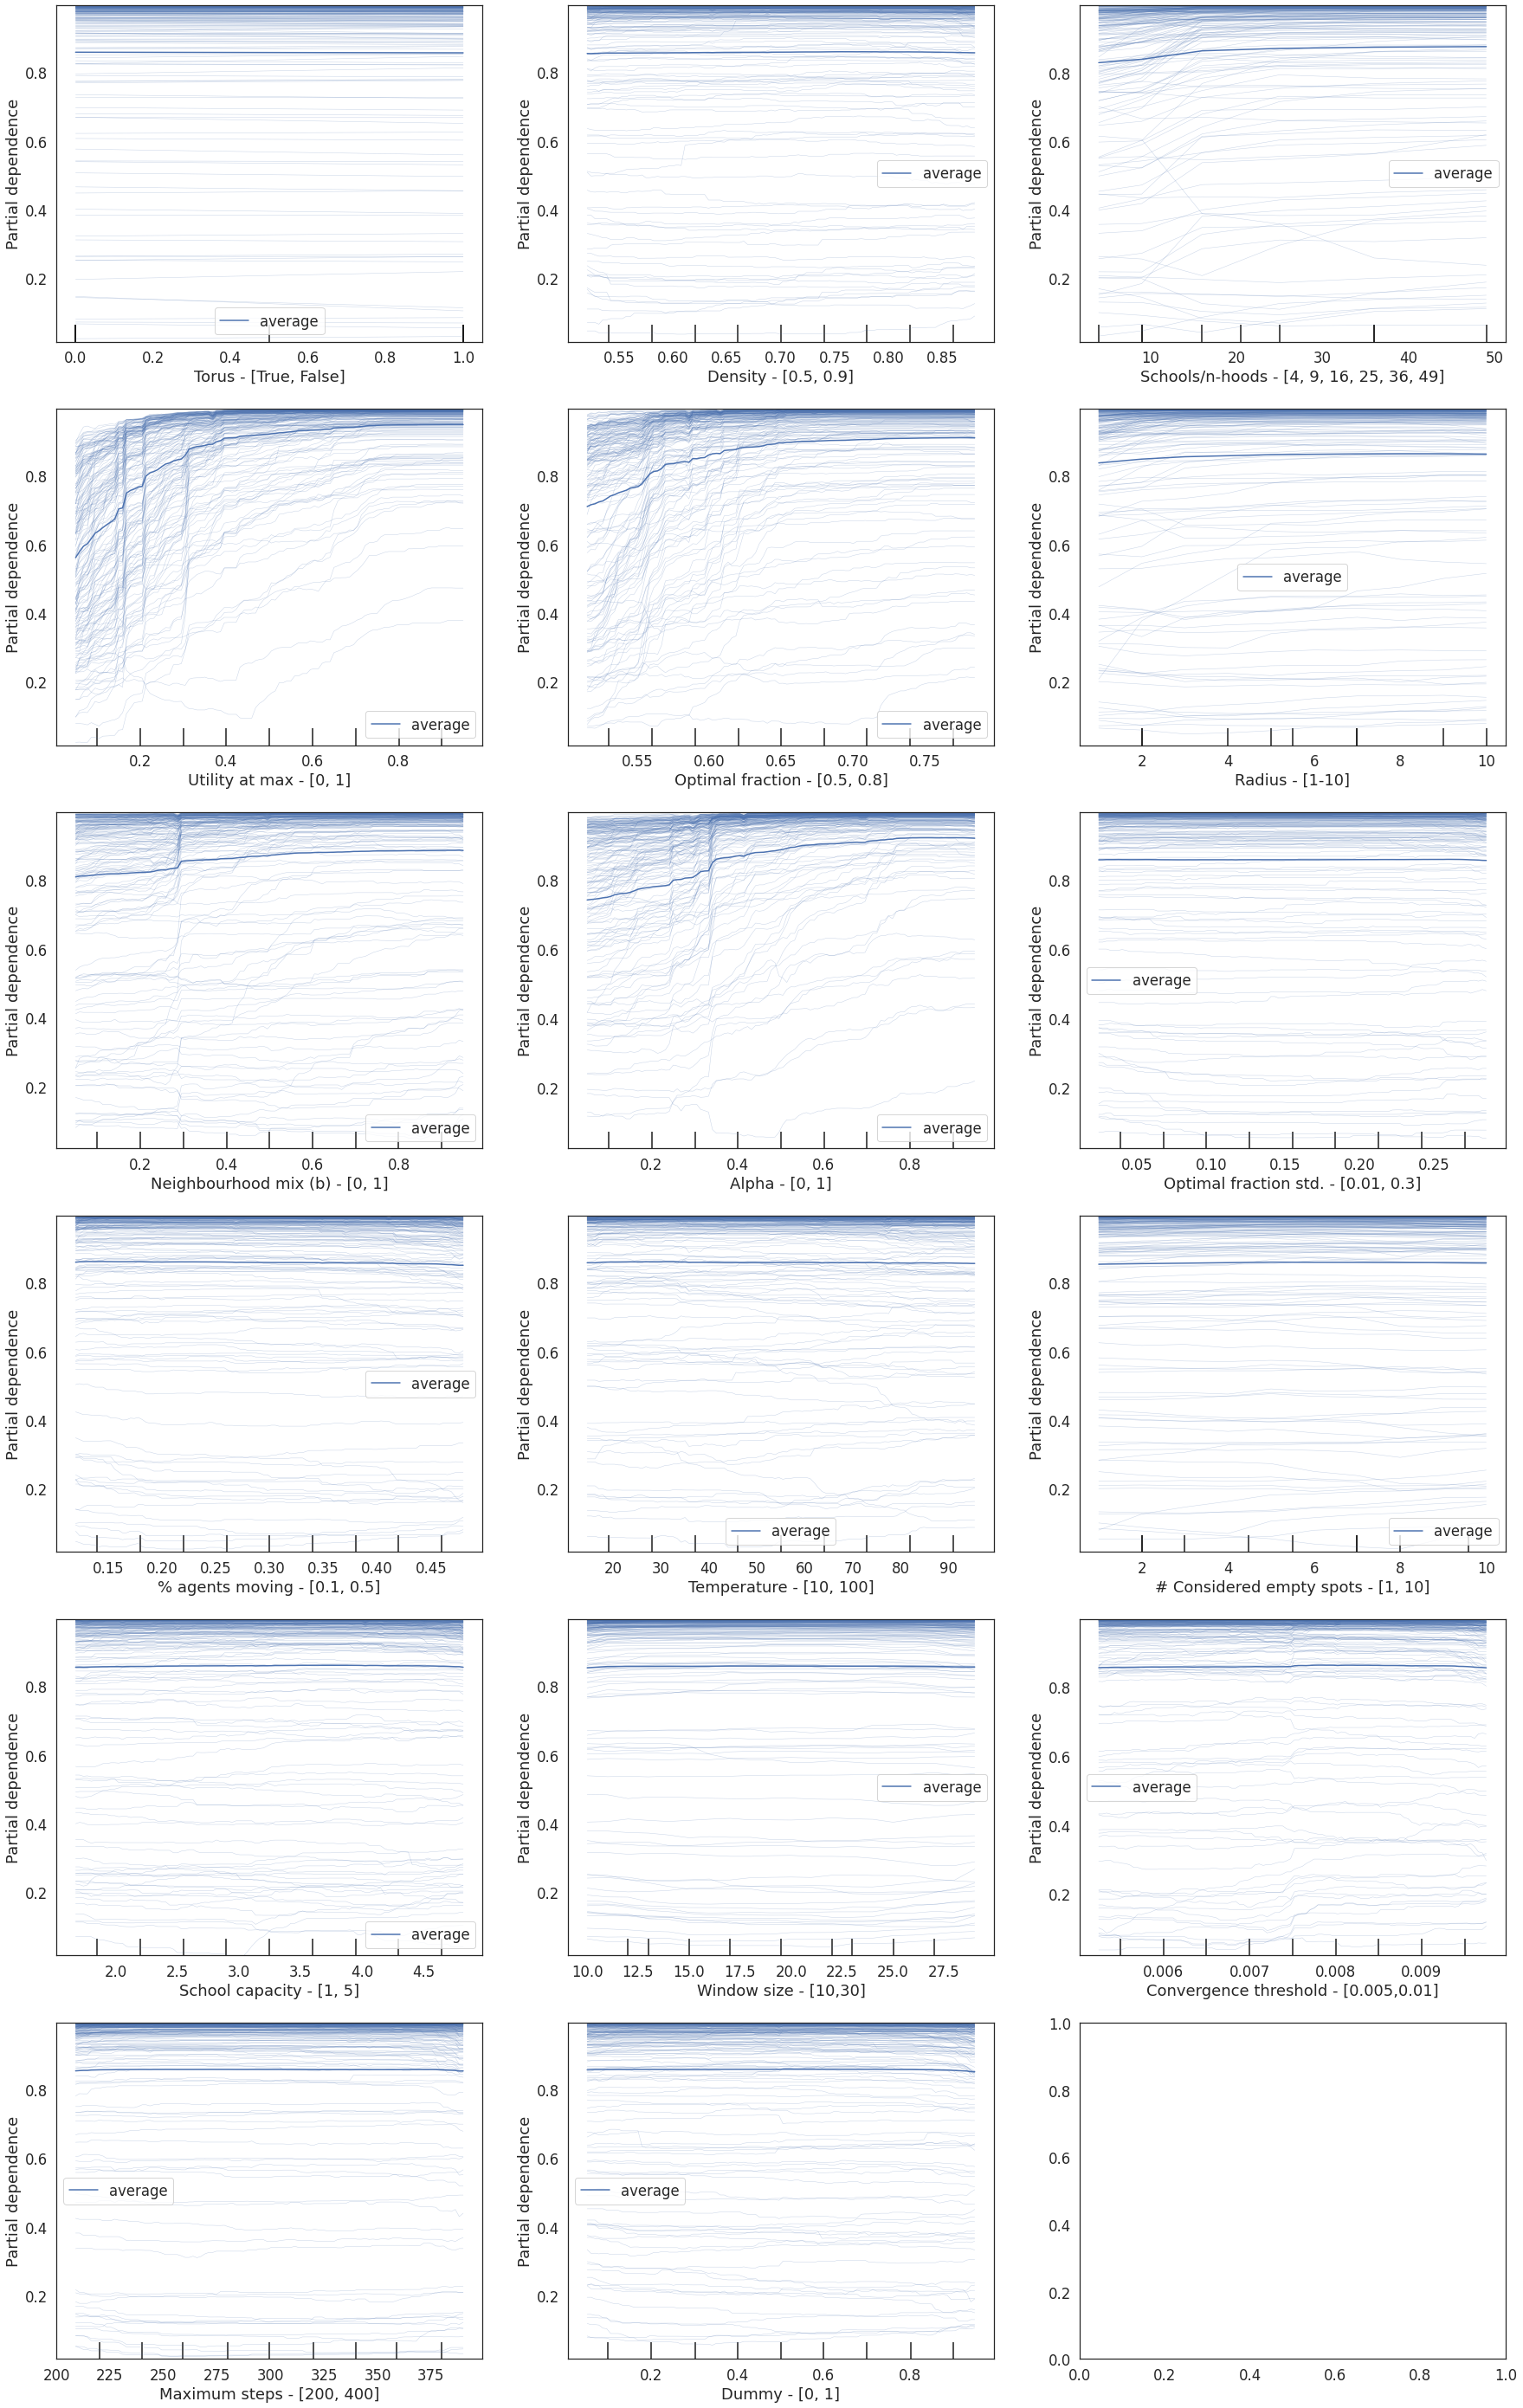

In [145]:
from sklearn.inspection import plot_partial_dependence

# Plot average and individual effects
_, ax = plt.subplots(ncols=3, nrows=6, figsize=(30, 50))
axs = ax.flatten()
for i, var in tqdm(enumerate(X.columns)):
    display = plot_partial_dependence(model, X, [var], 
                        kind='both', ax=axs[i], n_jobs=4, subsample=200)
            
plt.show()    

10it [00:16,  1.62s/it]


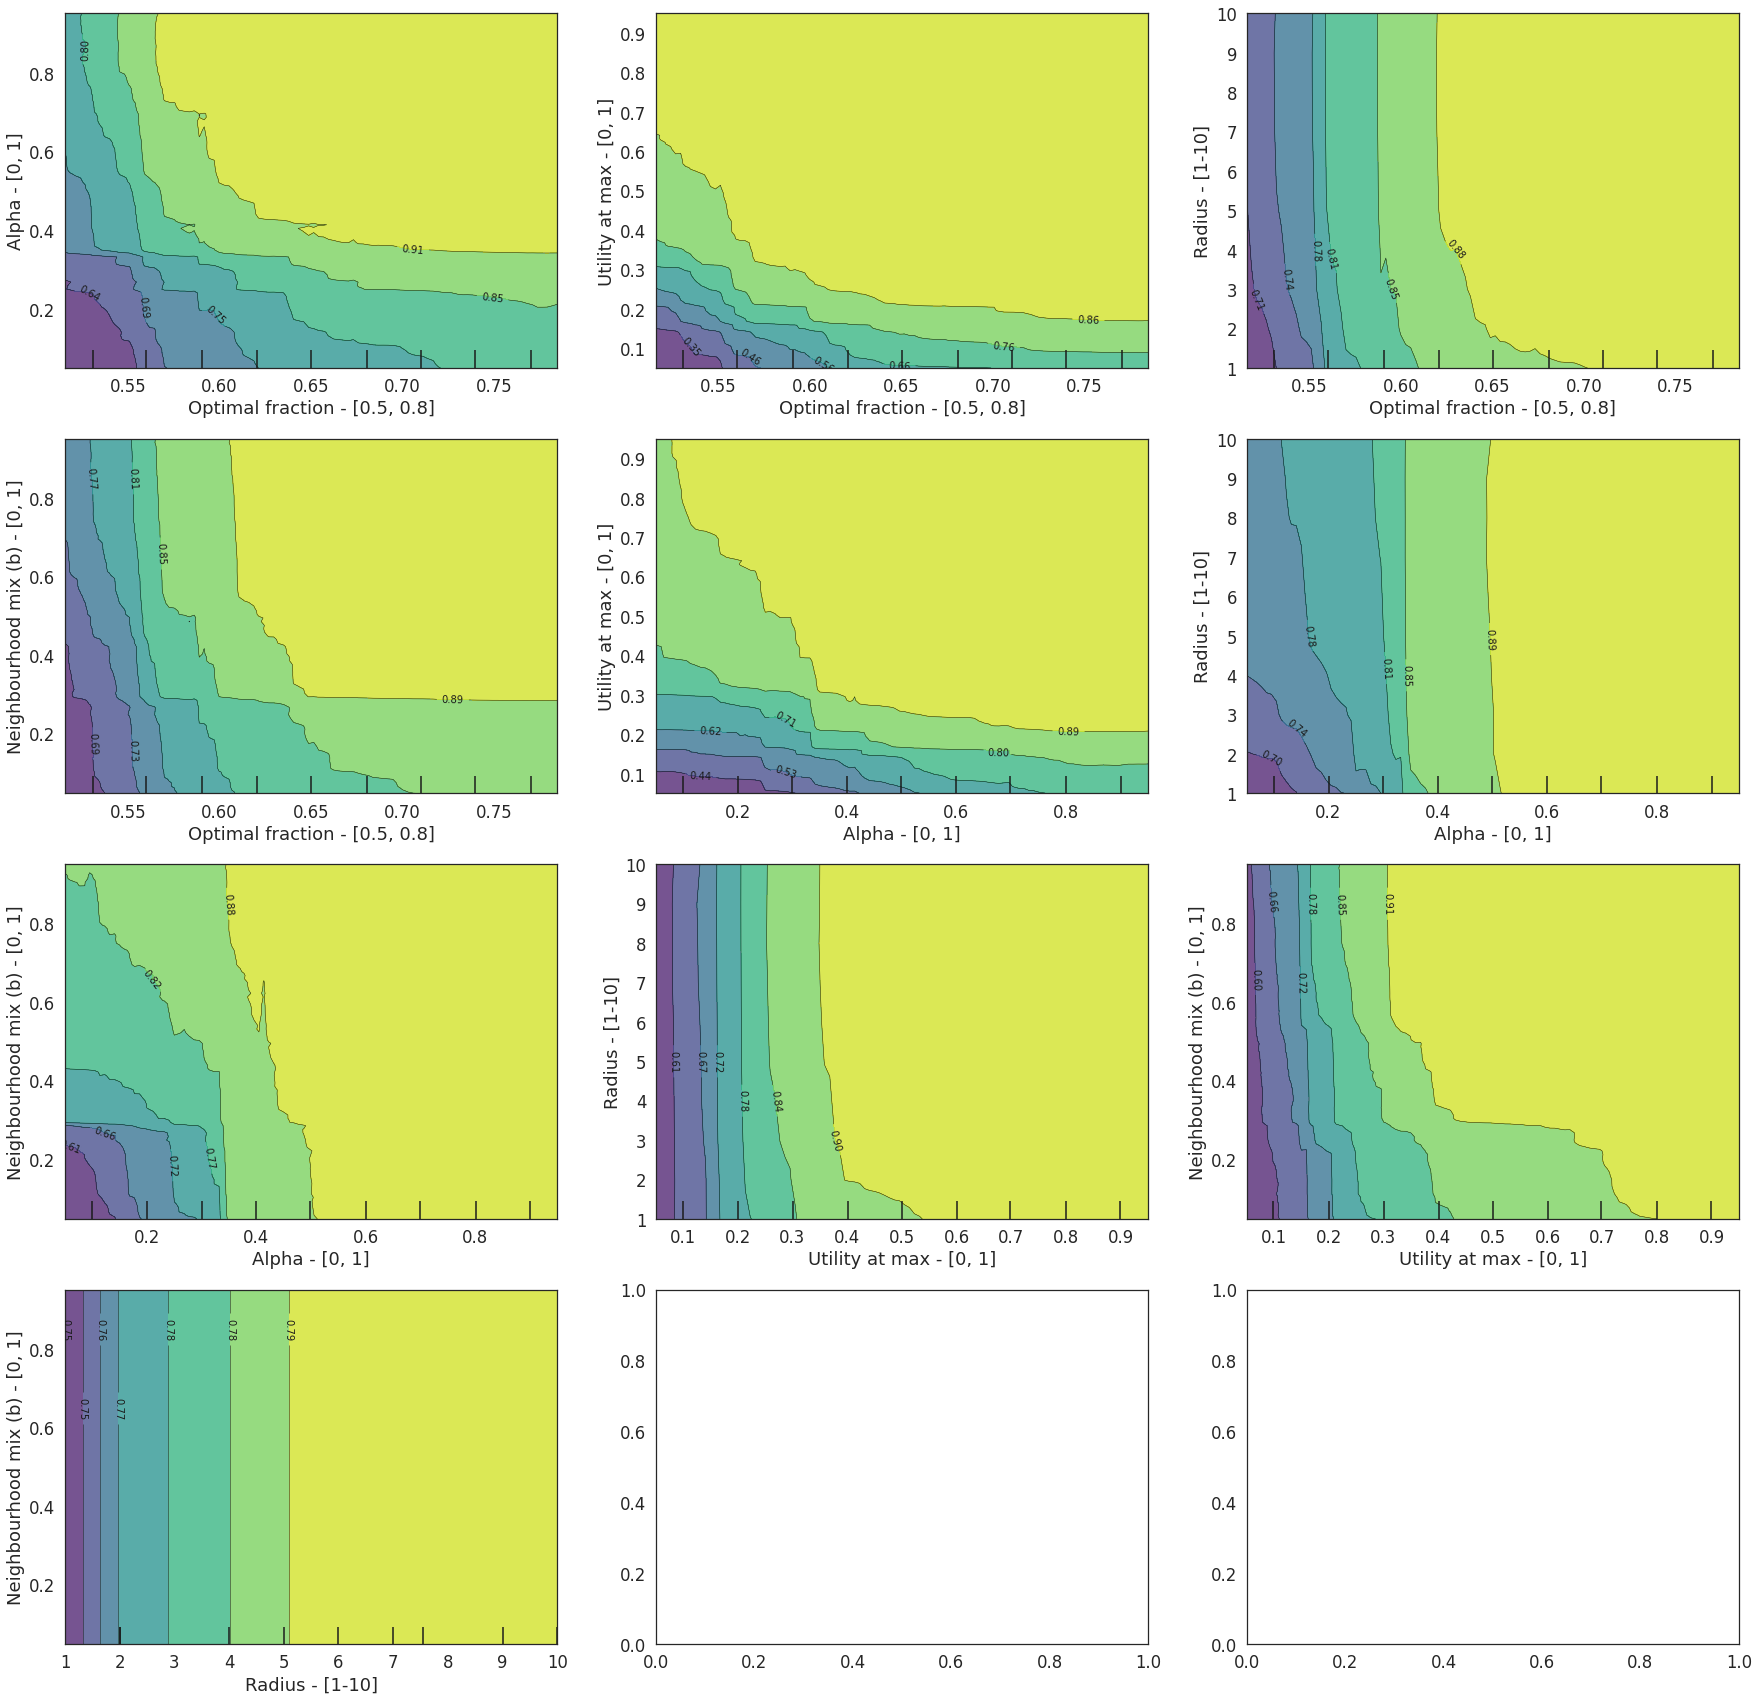

In [146]:
# Plot average interactions
subset = [names_bounds[name] for name in ['single_optimal_fraction', 
            'alpha', 'single_utility_at_max', 'radius', 'neighbourhood_mixture']]
interactions = combinations(subset, 2)
vmax = max([segregation_data[outcome].max() for outcome in outcomes_to_plot])
_, ax = plt.subplots(ncols=3, nrows=4, figsize=(30, 30))
axs = ax.flatten()
for i, names in tqdm(enumerate(interactions)):
    display = plot_partial_dependence(model, X_train, [names], 
                        kind='average', ax=axs[i], n_jobs=4, subsample=200,
                        contour_kw={'cmap':'viridis'})
plt.show()    

In [ ]:
# best_result = sm.Logit(y, sm.add_constant(X)).fit(method='nm', cov_type='HC0')

# iters = 10
# ll = 0
# for values in tqdm(np.random.uniform(-10, 10, size=(iters, len(coefs)+1))):
#     result = sm.GLM(y, sm.add_constant(X, prepend=False), family=sm.families.Binomial()
#                ).fit(start_params=values, maxiter=100, scale="X2", cov_type='HC3')
#     if result.llf < ll and not np.isinf(result.llf):
#         ll = result.llf
#         best_result = result
# print(best_result.summary())



# class vf(sm.families.varfuncs.VarianceFunction):
#     def __call__(self, mu):
#         return mu**2 * (1 - mu)**2

#     def deriv(self, mu):
#         return 2*mu - 6*mu**2 + 4*mu**3

# bin = sm.families.Binomial()
# bin.variance = vf()



# plt.clf()
# plt.grid(True)
# plt.plot(m.predict(linear=True), m.resid_pearson, 'o')
# plt.xlabel("Linear predictor")
# plt.ylabel("Residual")


# from scipy.special import loggamma
# from scipy.special import expit, logit

# def logLikelihood(params, y, X):
#     b = np.array(params[0:-1])      # the beta parameters of the regression model
#     phi = params[-1]                # the phi parameter
#     mu = expit(np.dot(X,b))
   
#     eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
#     res = - np.sum(loggamma(phi+eps) # the log likelihood
#                    - loggamma(mu*phi+eps) 
#                    - loggamma((1-mu)*phi+eps) 
#                    + (mu*phi-1)*np.log(y+eps) 
#                    + ((1-mu)*phi-1)*np.log(1-y+eps))

#     return res

# from scipy.optimize import minimize

# # initial parameters for optimization
# phi = 1
# b0 = 1
# x0 = np.array([b0,b0,b0,b0,b0,phi])

# res = minimize(logLikelihood, x0=x0, args=(y,X), bounds=[(None,None), 
#                                                          (None,None), 
#                                                          (None,None), 
#                                                          (None,None), 
#                                                          (None,None), 
#                                                          (0,None)])

# b = np.array(res.x[0:X.shape[1]])   # optimal regression parameters
# y_ = expit(np.dot(X,b))             # predictions  
# plt.plot(X[:,0], y_, ".")
# print(b*50)